In [1]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Datasets

In [2]:
# drugs
drugs = pd.read_csv('../data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('../data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('../data/combinations.csv', index_col=0)

In [3]:
# reduce cell lines to the 2128 most important genes

with open('../data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [4]:
combinations

,Drug_ID,Cell Line_ID,Y
0,Camptothecin,HCC1954,-0.251083
1,Camptothecin,HCC1143,1.343315
2,Camptothecin,HCC1187,1.736985
3,Camptothecin,HCC1395,-2.309078
4,Camptothecin,HCC1599,-3.106684
...,...,...,...
92698,JQ1,EFM-192A,3.576583
92699,JQ1,HCC1428,1.402466
92700,JQ1,HDQ-P1,2.762460
92701,JQ1,JIMT-1,3.442930


### Merge data

In [5]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [6]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_maccs)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Vinblastine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisplatin,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
Docetaxel,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
GSK591,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [8]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


In [9]:
# selected_columns = final_df.filter(regex='^fp', axis=1)
# selected_columns

In [10]:
# selected_columns = final_df.iloc[:, final_df.columns.get_loc('fp1023') + 1:]
# selected_columns

### Dataset splitting ###

In [9]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)

In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [11]:
y_test.describe()

count    18406.000000
mean         2.622640
std          2.754832
min         -8.085991
25%          1.367573
50%          3.094018
75%          4.570797
max          9.644137
Name: Y, dtype: float64

In [12]:
x_train_drugs = x_train.filter(regex='^fp', axis=1)
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('fp166') + 1:]

x_val_drugs = x_val.filter(regex='^fp', axis=1)
x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('fp166') + 1:]

x_test_drugs = x_test.filter(regex='^fp', axis=1)
x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('fp166') + 1:]

In [16]:
# from sklearn.preprocessing import StandardScaler
# scaler_train = StandardScaler()
# scaler_train.fit(x_train)
# x_train = scaler_train.transform(x_train)

# scaler_val = StandardScaler()
# scaler_val.fit(x_val)
# x_val = scaler_val.transform(x_val)

# scaler_test = StandardScaler()
# scaler_test.fit(x_test)
# x_test = scaler_test.transform(x_test)

### dense model

In [13]:
from models import DenseModel


# Example usage

model = DenseModel(x_train_cell_lines.values.shape[1], x_train_drugs.values.shape[1],expr_hlayers_sizes='[625, 312]', drug_hlayers_sizes='[1000, 500, 250]',predictor_hlayers_sizes='[1000]', hidden_dropout=0.3, optimizer='Adam')
print(model.summary())
model.train(x_train_cell_lines.values, x_train_drugs.values, y_train.values, epochs=100, batch_size=126)

val_loss, val_mae = model.evaluate(x_val_cell_lines.values, x_val_drugs.values, y_val.values)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines.values, x_test_drugs.values)
print(predictions)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 drug_input (InputLayer)        [(None, 167)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           20900       ['cell_line_input[0][0]']        
                                                                                                  
 dense_1 (Dense)                (None, 10)           1680        ['drug_input[0][0]']             
                                                                                              

c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
351/351 [==============================] - 7s 11ms/step - loss: 4.4197 - mae: 1.6106 - val_loss: 2.7587 - val_mae: 1.2809
Epoch 2/100
351/351 [==============================] - 3s 9ms/step - loss: 2.1527 - mae: 1.1312 - val_loss: 1.8793 - val_mae: 1.0615
Epoch 3/100
351/351 [==============================] - 3s 9ms/step - loss: 1.8435 - mae: 1.0425 - val_loss: 3.0229 - val_mae: 1.4318
Epoch 4/100
351/351 [==============================] - 3s 9ms/step - loss: 1.7232 - mae: 1.0045 - val_loss: 1.7262 - val_mae: 1.0019
Epoch 5/100
351/351 [==============================] - 3s 9ms/step - loss: 1.6566 - mae: 0.9830 - val_loss: 2.8043 - val_mae: 1.3633
Epoch 6/100
351/351 [==============================] - 3s 9ms/step - loss: 1.6126 - mae: 0.9713 - val_loss: 1.4564 - val_mae: 0.8968
Epoch 7/100
351/351 [==============================] - 3s 9ms/step - loss: 1.5363 - mae: 0.9495 - val_loss: 1.9294 - val_mae: 1.0399
Epoch 8/100
351/351 [==============================] - 3s 9ms/s

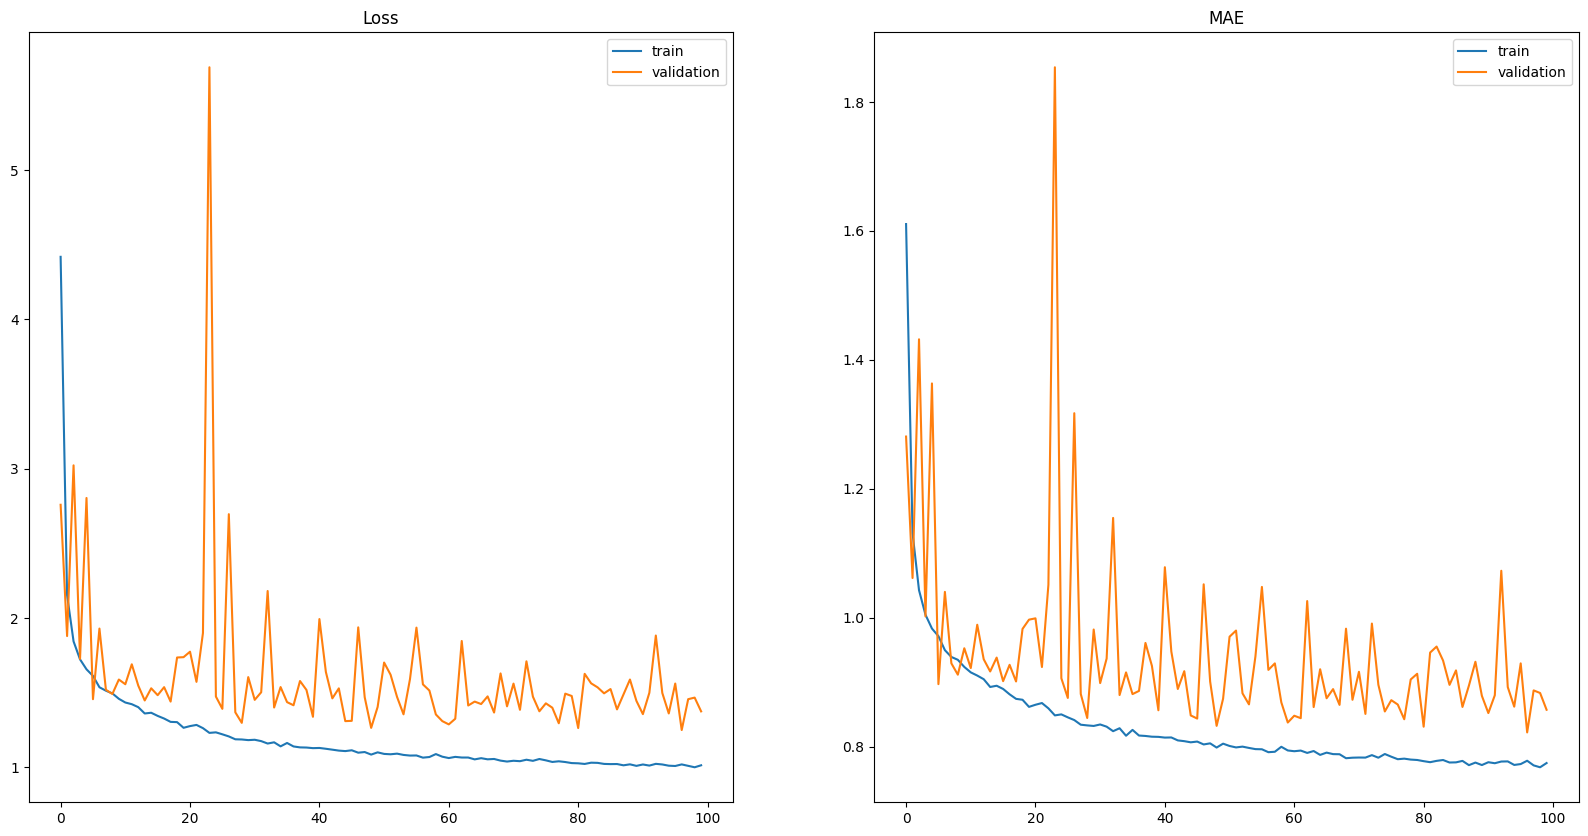

In [14]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()



